# Tiny object detection

##Модуль загрузки данных

In [ ]:
#  !pip install opencv-python-headless==4.5.2.52
# ! pip install --upgrade albumentations

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Github
%cd 'LacmusTflite'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/LacmusTflite


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import albumentations as A

In [ ]:
B = 0
#k=1.2
k=1
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * k)
os.listdir(DATA_DIR)

['JPEGImages', 'ImageSets', 'Annotations']

In [ ]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

with open(DATA_DIR+'/ImageSets/Main/train.txt') as f:
    train_i = f.read().split('\n')[:-1]

train_idxs = [int(t) for t in train_i]

In [ ]:
len(test_idxs)

45

##Модуль формирования и препроцессинга данных

In [ ]:

def augment(img_array, anns, nn_crop_size, feature_map_size):
    """Get big crop with bboxes and augment
    return crop for NN and labels """
    big_crop_size, other_size, _ = img_array.shape
    assert big_crop_size == other_size
    bboxes = [ann_to_numpy(a) for a in anns]
    category_ids = [1]*len(bboxes)
    
    bbox_params = A.BboxParams(
        format='pascal_voc',
        label_fields=['category_ids'])
    
    transform = A.Compose([
        A.RandomCrop(nn_crop_size, nn_crop_size),
        A.Flip(),
        A.RandomBrightnessContrast(),
        A.Rotate (limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
    ], 
        bbox_params=bbox_params
    )
    
    aug = transform(
        image=img_array, 
        bboxes=bboxes, 
        category_ids=category_ids
    )
    # print(aug['bboxes'])
    aug_y = get_feature_map(
        aug['bboxes'],
        nn_crop_size, 
        feature_map_size)
    
    return aug['image'], aug_y

In [ ]:
_, x, _, anns  = crop_sample(1, BIG_CROP_SIZE, FEATURE_MAP_SIZE)[0]

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)


In [ ]:
aug_x.shape

(224, 224, 3)

In [ ]:
def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        
def train_gen():
    for i in train_idxs:
        out = crop_sample(i, BIG_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, _, anns = o
            aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
            yield aug_x, aug_y

In [ ]:
len(crop_sample(train_idxs[0], BIG_CROP_SIZE, FEATURE_MAP_SIZE))

4

In [ ]:
len(crop_sample(train_idxs[0], BIG_CROP_SIZE, FEATURE_MAP_SIZE)[0])

4

In [ ]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_generator(
     train_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4,seed=666).batch(BATCH_SIZE, drop_remainder=True).prefetch(BATCH_SIZE)

### Test crop_sample()

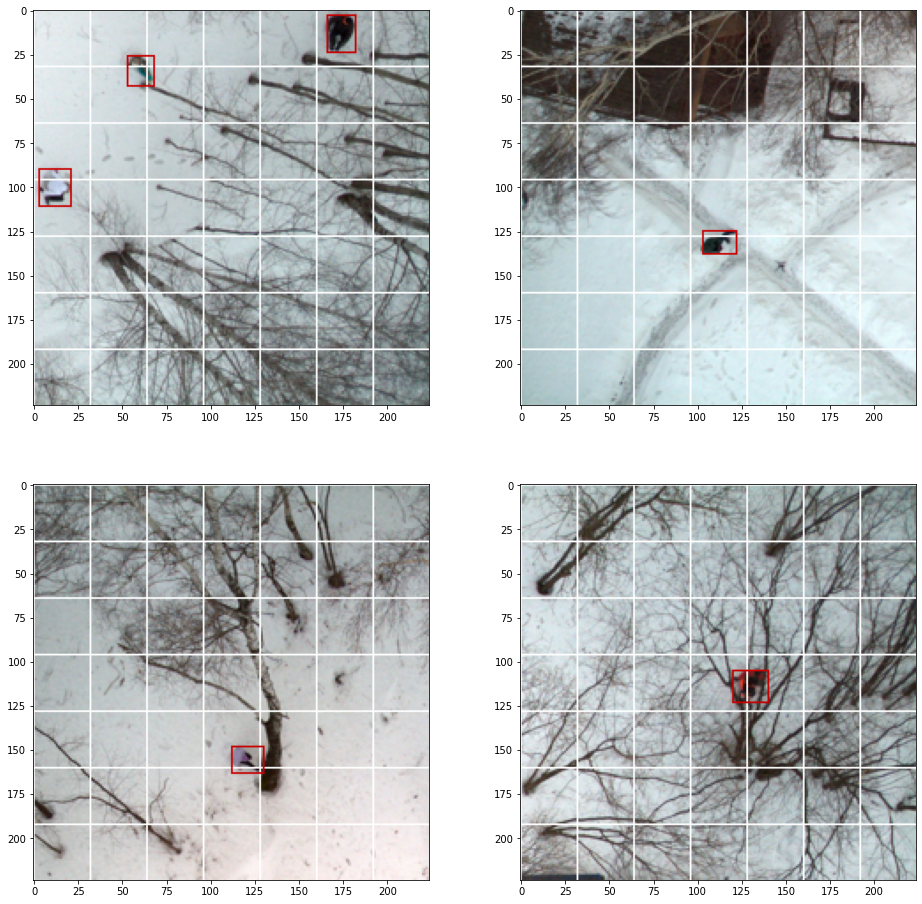

In [ ]:
out = crop_sample(0, CROP_SIZE=INPUT_CROP_SIZE, FEATURE_MAP_SIZE=FEATURE_MAP_SIZE)
plt.figure(figsize=(16,16))

for i in range(4):
    crop_idx, img_arr, y, anns = out[i]
    img = tf.keras.utils.array_to_img(img_arr)
    draw = ImageDraw.Draw(img)
    w,h = img.size
    ff = 32
    for f in range(FEATURE_MAP_SIZE):
        draw.line((ff*f, 0, ff*f, h))
        draw.line((0, ff*f, w, ff*f))
        
    for a in anns:
        bb = a.bbox
        draw.rectangle(bb, outline=(200,0,0))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()

### Test dataset

In [ ]:
it = iter(test_dataset)

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape

(TensorShape([8, 224, 224, 3]), TensorShape([8, 7, 7]))

In [ ]:
np.array(np.where(y==1))

array([[3],
       [4]])

In [ ]:
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()
    try:
        img = tf.keras.utils.array_to_img(img_arr)
        xy = np.array(np.where(y==1)).ravel()[::-1]
        bb = np.array([xy, xy+1]).ravel() * 32

        draw = ImageDraw.Draw(img)
        draw.rectangle(bb.tolist(), outline=(200,0,0))
        y_img = Image.fromarray(y*255)
        y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))
    except TypeError:
        continue
        
    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()    

<Figure size 1152x1152 with 0 Axes>

### Train dataset

In [ ]:
it = iter(train_dataset)

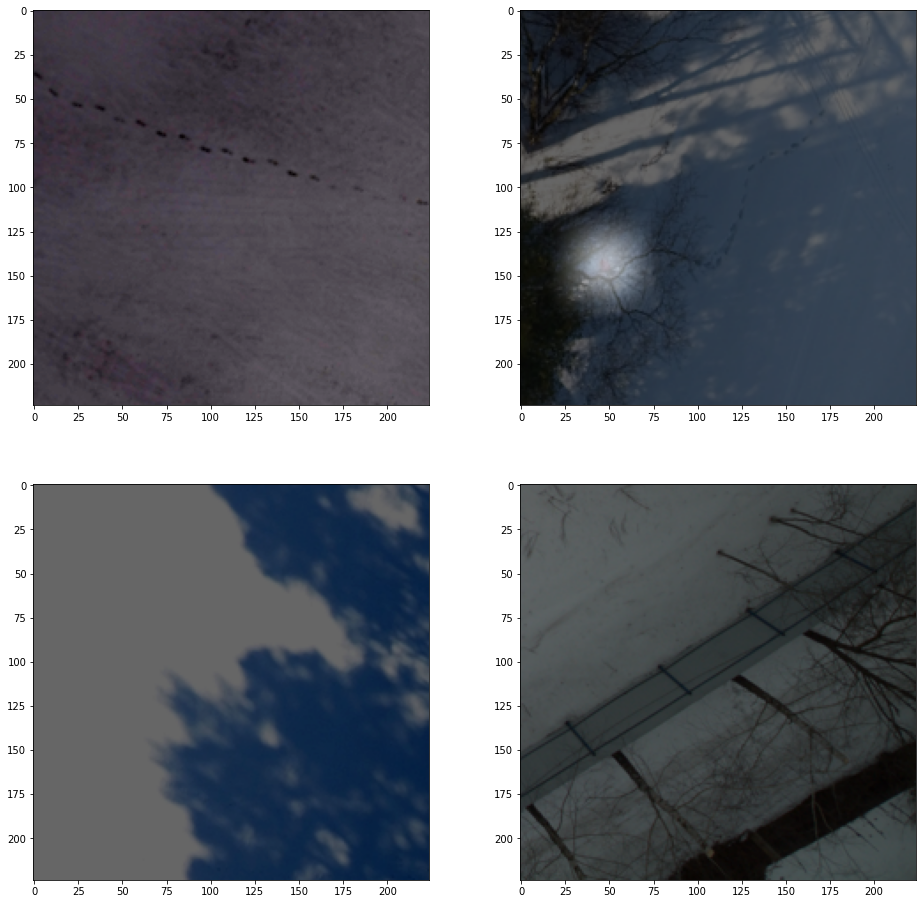

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()

    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()   

##Модуль формирования модели

## Backbone loading

In [ ]:
model_name = f'B{B}'
model = tf.keras.applications.EfficientNetB0(weights = "imagenet", include_top=False)
model.save('backbones/B0')
#backbone = tf.keras.models.load_model('EnetB0.h5')
backbone=tf.keras.models.load_model(f'backbones/{model_name}')

backbone.summary()

16719872/16705208 [==============================] - 0s 0us/step
INFO:tensorflow:Assets written to: backbones/B0/assets
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7          

In [ ]:
x, y_true = next(it)
# x = tf.expand_dims(x, 0)
y_pred = backbone(x)
y_pred.shape

TensorShape([8, 7, 7, 1280])

### Pedestrian detection model

In [ ]:
class PeDet(tf.keras.Model):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.backbone.trainable = False
        # self.backbone.layers[-3].trainable=True
        # self.backbone.layers[-2].trainable=True
        #self.backbone.layers[-1].trainable=True
        self.dense1 = tf.keras.layers.Dense(256
                                            #, activation=  'relu'
           ,kernel_initializer=tf.keras.initializers.HeNormal(seed=None) 
          )
        self.act1=tf.keras.layers.PReLU(
            alpha_initializer='zeros',
            alpha_regularizer=None,
            alpha_constraint=None,
            shared_axes=None,
            )
        self.dense2 = tf.keras.layers.Dense(128
                                            # , activation=  'relu'
           ,kernel_initializer=tf.keras.initializers.HeNormal(seed=None) 
          )
        self.act2=tf.keras.layers.PReLU(
            alpha_initializer='zeros',
            alpha_regularizer=None,
            alpha_constraint=None,
            shared_axes=None,
            )
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.backbone(x)
        out = self.dense1(out)
        out = self.act1(out)
        out = self.dense2(out)
        out = self.act2(out)
        out = self.dense3(out)
        return out

In [ ]:
pedet = PeDet(backbone)

##Модуль обучения

In [ ]:
THRESH = 0.3
LOG_DIR = f'./logs/GPU{B}'

precision = tf.keras.metrics.Precision(thresholds=THRESH)
recall = tf.keras.metrics.Recall(thresholds=THRESH)
auc = tf.keras.metrics.AUC()

In [ ]:
! rm -rf {LOG_DIR}

In [ ]:
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    update_freq='epoch'
)

In [ ]:
# initial_learning_rate = 1e-4
# lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1500,
#     decay_rate=0.7,
#     staircase=True)

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=64000
    #,alpha=0.3
    )

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# optimizer =tf.keras.optimizers.RMSprop(
#     learning_rate=lr_scheduler,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,/*
#     name="RMSprop")

pedet.compile(optimizer=optimizer, 
              loss=focal_loss, 
              metrics=[precision, recall, auc])

In [ ]:
hist = pedet.fit(train_dataset, 
                 validation_data=test_dataset, 
                 epochs=64,
                callbacks=[tbc]
        )

Epoch 1/64
183/183 [==============================] - 478s 3s/step - loss: 3.8485 - precision: 0.3088 - recall: 0.5210 - auc: 0.9141 - val_loss: 1.1871 - val_precision: 0.4815 - val_recall: 0.8320 - val_auc: 0.9891
Epoch 2/64
183/183 [==============================] - 231s 1s/step - loss: 1.6384 - precision: 0.5160 - recall: 0.6568 - auc: 0.9715 - val_loss: 0.8401 - val_precision: 0.5934 - val_recall: 0.8640 - val_auc: 0.9947
Epoch 3/64
183/183 [==============================] - 220s 1s/step - loss: 1.3458 - precision: 0.5633 - recall: 0.7325 - auc: 0.9817 - val_loss: 0.8859 - val_precision: 0.5747 - val_recall: 0.8000 - val_auc: 0.9948
Epoch 4/64
183/183 [==============================] - 224s 1s/step - loss: 1.3017 - precision: 0.5456 - recall: 0.7375 - auc: 0.9833 - val_loss: 0.7606 - val_precision: 0.5936 - val_recall: 0.8880 - val_auc: 0.9962
Epoch 5/64
183/183 [==============================] - 222s 1s/step - loss: 1.2189 - precision: 0.5640 - recall: 0.7585 - auc: 0.9851 - val_l

In [ ]:
pedet.save(f'snapshots/{model_name}')

INFO:tensorflow:Assets written to: snapshots/B0/assets


##Модуль метрик качества модели и визуализации

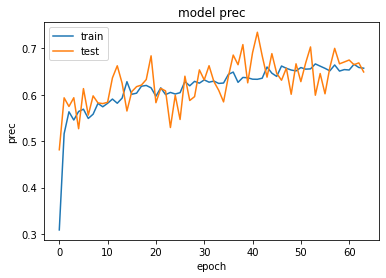

In [ ]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('model prec')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


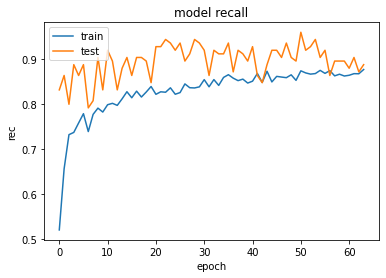

In [ ]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('rec')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

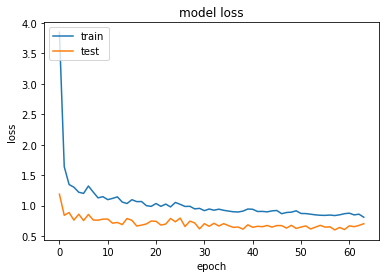

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [ ]:
model = tf.keras.models.load_model(f'snapshots/{model_name}', compile=False )

In [ ]:
pred=model.predict(test_dataset)
y = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
l=list(np.round(np.arange(0,1.01,0.01),2))
thr=0.3
spec=[]
rec=[]
prec=[]
acc=[]
pcor=[]
for i in l:
  cm = confusion_matrix(y.reshape(-1), pred.reshape(-1)>i)
  spec.append(cm[0,0]/(cm[0,0]+cm[0,1]))
  rec.append(cm[1,1]/(cm[1,0]+cm[1,1]))
  prec.append(cm[1,1]/(cm[1,1]+cm[0,1]))
  acc.append((cm[1,1]+cm[0,0])/sum(cm.ravel()))
  pcor.append(cm[0,0]/(cm[0,0]+cm[1,0]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [ ]:
fscore=[]
f2score=[]
b=2
for i in range(len(prec)):
  fscore.append(2*prec[i]*rec[i]/(rec[i]+prec[i]))
  f2score.append((1+b**2)*prec[i]*rec[i]/(rec[i]+b**2 * prec[i]))

Text(0.5, 0, 'threshold')

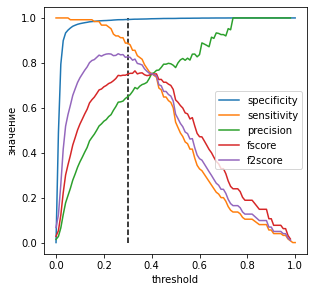

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(thr, 0,1,ls='--')
plt.legend( ('specificity', 'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)>0.3,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.993     0.996      8695
           1      0.649     0.888     0.750       125

    accuracy                          0.992      8820
   macro avg      0.824     0.941     0.873      8820
weighted avg      0.993     0.992     0.992      8820



In [ ]:
f_thr=(np.nanargmax(np.array(f2score)))/100
f_thr

0.26

Text(0.5, 0, 'threshold')

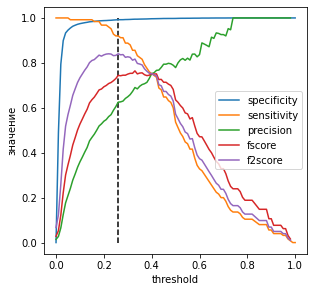

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(f_thr, 0,1,ls='--')
plt.legend( ('specificity', 'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)> f_thr,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.992     0.995      8695
           1      0.625     0.920     0.744       125

    accuracy                          0.991      8820
   macro avg      0.812     0.956     0.870      8820
weighted avg      0.994     0.991     0.992      8820



In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y.reshape(-1), pred.reshape(-1)> f_thr)

print(cf_matrix)

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()